In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns

In [3]:
file = 'data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


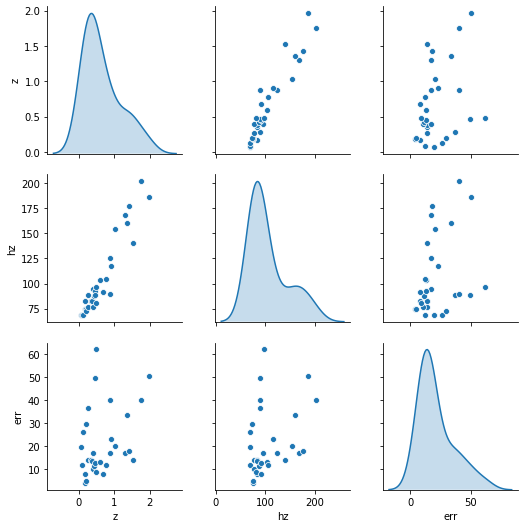

In [4]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistHD.png")

In [5]:
a = np.array([25,  3,  9,  7, 19,  2, 17, 16,  6, 28, 12, 20, 21, 26, 27, 11,  1,
       10, 30, 13, 29,  0,  8, 18, 24,  5, 23,  4, 22, 15, 14])
randomize = np.random.permutation(len(data.values))
data = data.values[randomize]
randomize

array([25,  3,  9,  7, 19,  2, 17, 16,  6, 28, 12, 20, 21, 26, 27, 11,  1,
       10, 30, 13, 29,  0,  8, 18, 24,  5, 23,  4, 22, 15, 14])

In [6]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [7]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [8]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [9]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = RandomNormal()


In [12]:
# def autoencoder(input_z):
#     #encoder
#     efirst = Dense(100, kernel_initializer=initializer, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, kernel_initializer=initializer, activation='relu')(efirst)
#     elast = Dense(50, kernel_initializer=initializer, activation='relu')(ehidden)
#     #coded
#     coded = Dense(10, kernel_initializer=initializer, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, kernel_initializer=initializer, activation='relu')(coded)
#     dhidden = Dense(50, kernel_initializer=initializer, activation='relu')(dfirst)
#     dlast = Dense(100, kernel_initializer=initializer, activation='relu')(dhidden)
#     decoded = Dense(2, kernel_initializer=initializer, activation='relu')(dlast)
    
#     return decoded

In [13]:
def autoencoder(input_z):
    #encoder
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    elast = Dense(50, activation='relu')(ehidden)
    coded = Dense(10, activation='relu')(elast)
    #decoder 
    dfirst = Dense(50, activation='relu')(coded)
    dhidden = Dense(50, activation='relu')(dfirst)
    dlast = Dense(100, activation='relu')(dhidden)
    decoded = Dense(2, activation='relu')(dlast)
    
    return decoded

In [14]:
# batch_size = 4
batch_size = 4
epochs = 500
input_z = Input(shape = (1,))

In [15]:
autoencoder = Model(input_z, autoencoder(input_z))
autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_5 (Dense)              (None, 50)               

In [16]:
autoencoder_train = autoencoder.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test),
                                    callbacks=callbacks)

Epoch 1/500
6/6 [==============================] - 0s 19ms/step - loss: 6951.6953 - val_loss: 5591.8125
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 6926.6323 - val_loss: 5567.0737
Epoch 3/500
6/6 [==============================] - 0s 4ms/step - loss: 6884.0815 - val_loss: 5517.2476
Epoch 4/500
6/6 [==============================] - 0s 4ms/step - loss: 6783.1069 - val_loss: 5410.0127
Epoch 5/500
6/6 [==============================] - 0s 4ms/step - loss: 6561.3394 - val_loss: 5179.1914
Epoch 6/500
6/6 [==============================] - 0s 4ms/step - loss: 6117.1616 - val_loss: 4695.3789
Epoch 7/500
6/6 [==============================] - 0s 4ms/step - loss: 5104.5542 - val_loss: 3737.8105
Epoch 8/500
6/6 [==============================] - 0s 5ms/step - loss: 3399.7891 - val_loss: 2194.1072
Epoch 9/500
6/6 [==============================] - 0s 5ms/step - loss: 1560.5287 - val_loss: 1129.2296
Epoch 10/500
6/6 [==============================] - 0s 4ms/step - loss: 

6/6 [==============================] - 0s 3ms/step - loss: 150.4962 - val_loss: 218.6044
Epoch 82/500
6/6 [==============================] - 0s 3ms/step - loss: 151.8463 - val_loss: 216.6315
Epoch 83/500
6/6 [==============================] - 0s 3ms/step - loss: 153.7808 - val_loss: 214.6576
Epoch 84/500
6/6 [==============================] - 0s 3ms/step - loss: 148.1623 - val_loss: 215.1330
Epoch 85/500
6/6 [==============================] - 0s 3ms/step - loss: 157.5284 - val_loss: 219.3092
Epoch 86/500
6/6 [==============================] - 0s 3ms/step - loss: 159.6573 - val_loss: 217.5040
Epoch 87/500
6/6 [==============================] - 0s 4ms/step - loss: 158.6282 - val_loss: 220.9444
Epoch 88/500
6/6 [==============================] - 0s 4ms/step - loss: 150.9858 - val_loss: 213.2431
Epoch 89/500
6/6 [==============================] - 0s 4ms/step - loss: 151.5355 - val_loss: 216.9687
Epoch 90/500
6/6 [==============================] - 0s 4ms/step - loss: 147.1586 - val_loss: 21

Epoch 161/500
6/6 [==============================] - 0s 3ms/step - loss: 146.1932 - val_loss: 212.7919
Epoch 162/500
6/6 [==============================] - 0s 3ms/step - loss: 168.1491 - val_loss: 224.5907
Epoch 163/500
6/6 [==============================] - 0s 3ms/step - loss: 132.9226 - val_loss: 216.7126
Epoch 164/500
6/6 [==============================] - 0s 3ms/step - loss: 153.2338 - val_loss: 212.5753
Epoch 165/500
6/6 [==============================] - 0s 3ms/step - loss: 148.0476 - val_loss: 215.6986
Epoch 166/500
6/6 [==============================] - 0s 4ms/step - loss: 142.8993 - val_loss: 214.7369
Epoch 167/500
6/6 [==============================] - 0s 3ms/step - loss: 144.4192 - val_loss: 214.8303
Epoch 168/500
6/6 [==============================] - 0s 3ms/step - loss: 144.9604 - val_loss: 213.7163
Epoch 169/500
6/6 [==============================] - 0s 3ms/step - loss: 153.6404 - val_loss: 222.6365
Epoch 170/500
6/6 [==============================] - 0s 3ms/step - loss: 

6/6 [==============================] - 0s 3ms/step - loss: 157.2564 - val_loss: 213.0421
Epoch 241/500
6/6 [==============================] - 0s 4ms/step - loss: 140.7446 - val_loss: 219.4532
Epoch 242/500
6/6 [==============================] - 0s 4ms/step - loss: 148.6739 - val_loss: 214.9106
Epoch 243/500
6/6 [==============================] - 0s 3ms/step - loss: 146.0190 - val_loss: 217.5051
Epoch 244/500
6/6 [==============================] - 0s 4ms/step - loss: 139.3421 - val_loss: 217.2982
Epoch 245/500
6/6 [==============================] - 0s 4ms/step - loss: 141.2397 - val_loss: 216.6265
Epoch 246/500
6/6 [==============================] - 0s 4ms/step - loss: 146.6057 - val_loss: 211.7891
Epoch 247/500
6/6 [==============================] - 0s 4ms/step - loss: 182.0276 - val_loss: 222.4034
Epoch 248/500
6/6 [==============================] - 0s 3ms/step - loss: 133.8769 - val_loss: 217.9451
Epoch 249/500
6/6 [==============================] - 0s 3ms/step - loss: 151.5109 - val

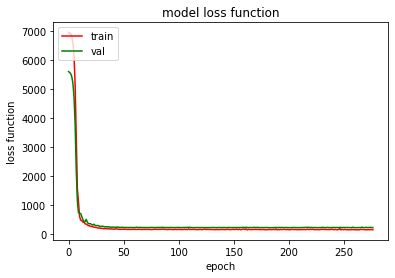

In [17]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
plt.title('model loss function')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_ae.png")
# plt.savefig("LOSS_Overfitting_synthetic_HD.png")

In [18]:
#uncer net
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
unet**2, np.min(autoencoder_train.history['loss'])


(210.1192626953125, 132.922607421875)

In [19]:
pred = autoencoder.predict(z_test)
pred

array([[131.14928 ,  24.902306],
       [ 76.55852 ,  15.785343],
       [119.70383 ,  22.85363 ],
       [ 75.69385 ,  15.649758],
       [117.99097 ,  22.549974],
       [ 89.94249 ,  17.929462],
       [ 88.52611 ,  17.698292]], dtype=float32)

In [20]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [21]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = autoencoder.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


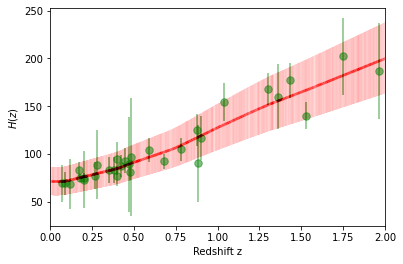

In [22]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.005)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.savefig("Overfitting_synthetic_HD.png")

In [23]:
# Cosmological constants
Om = 0.27
# variance network


In [24]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

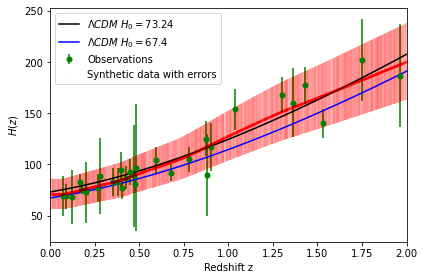

In [25]:
z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

plt.savefig("SyntheticHDrelu.png",dpi=800)

In [26]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [42]:
randomselection = np.random.randint(0,1000,100)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [43]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


np.savetxt("autoEncoderHz100.dat",mookHz, delimiter=" ")

In [44]:
predy_reduced[:,1]

array([31.847252, 30.701782, 18.981773, 30.795956, 28.993635, 36.256897,
       26.377825, 19.298883, 35.83636 , 14.958278, 21.037855, 14.983868,
       17.98049 , 17.812056, 16.700695, 17.812056, 18.947802, 21.805933,
       23.138794, 33.06885 , 30.000885, 31.847252, 18.011698, 17.268623,
       19.634115, 23.286905, 18.561174, 19.362206, 23.53951 , 32.7722  ,
       17.229824, 20.955952, 23.343115, 20.951767, 36.760464, 24.233702,
       20.732801, 32.360176, 28.298445, 23.888863, 24.543272, 19.066277,
       32.664635, 18.12279 , 23.171532, 33.7555  , 23.164587, 15.835453,
       17.364931, 19.584534, 25.356993, 28.968363, 26.966509, 27.269936,
       21.830389, 21.604729, 18.012323, 15.268331, 23.123411, 28.801386,
       15.078221, 32.394485, 35.83636 , 30.590921, 26.698051, 36.869514,
       28.814203, 22.92661 , 30.191378, 23.836231, 18.7877  , 33.400105,
       18.466606, 32.102634, 14.955482, 21.118326, 18.526464, 17.229824,
       15.247173, 30.94033 , 33.016697, 19.362206, 

In [45]:
error  = predy_reduced[:,1]**2
error

array([1014.24744,  942.5994 ,  360.3077 ,  948.39087,  840.63086,
       1314.5626 ,  695.7896 ,  372.4469 , 1284.2448 ,  223.75008,
        442.59134,  224.5163 ,  323.298  ,  317.26932,  278.9132 ,
        317.26932,  359.0192 ,  475.49872,  535.4038 , 1093.549  ,
        900.0531 , 1014.24744,  324.42126,  298.20535,  385.49847,
        542.27997,  344.51718,  374.895  ,  554.1086 , 1074.0172 ,
        296.86685,  439.15192,  544.901  ,  438.97653, 1351.3317 ,
        587.2723 ,  429.84906, 1047.181  ,  800.802  ,  570.67773,
        602.3722 ,  363.5229 , 1066.9784 ,  328.4355 ,  536.91986,
       1139.4338 ,  536.5981 ,  250.76157,  301.54083,  383.55396,
        642.97705,  839.166  ,  727.1926 ,  743.6494 ,  476.5659 ,
        466.7643 ,  324.4438 ,  233.12192,  534.69214,  829.51984,
        227.35275, 1049.4027 , 1284.2448 ,  935.80444,  712.78595,
       1359.3611 ,  830.2583 ,  525.6295 ,  911.5193 ,  568.1659 ,
        352.9777 , 1115.567  ,  341.01553, 1030.5791 ,  223.66

In [46]:
diagcov = np.diag(error) #inverso
np.savetxt("autoEncoderHz_cov100.dat", diagcov, delimiter= " ", header="#100 100")
np.shape(diagcov)

(100, 100)

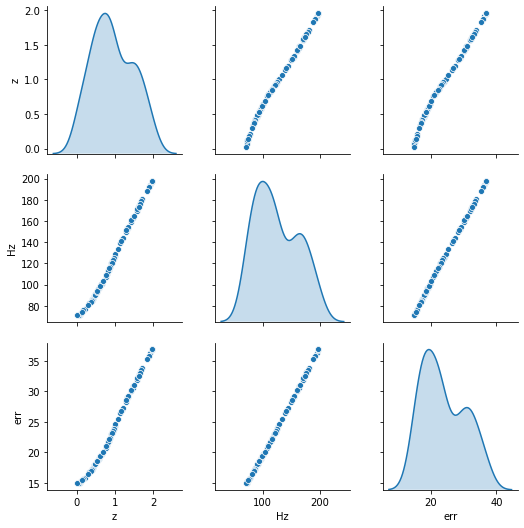

In [47]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
plt.savefig("100hdmook.png")